In [ ]:
!pip install -q -U trl transformers accelerate git+https://github.com/huggingface/peft.git
!pip install -q datasets bitsandbytes einops wandb

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
from transformers import pipeline

In [ ]:
import json
import os
import pandas as pd

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [ ]:
with open("/content/Train_dataset.json") as json_file:
    Train_data = json.load(json_file)
with open("/content/Valid_dataset.json") as json_file:
    Validation_data = json.load(json_file)

In [ ]:
print(Train_data[0])
print(Validation_data[0])

{'input': 'Fingerprint Security Lock', 'output': ['Brainstormed on a security system to be guarded by fingerprints using an AS608 fingerprint sensor', 'Implemented this model using an Arduino UNO Breakout board along with a Relay Module.']}
{'input': 'Lego Image Classifier - Computer Vision, Self Project', 'output': ['Built a multi-class classifier with Keras, which can classify Lego images into 16 distinct classes using state of the art VGG16 algorithm, achieving 95% training accuracy', 'Given data was a folder containing 4500 images and a CSV file with respective class labels. Using Python, segregated them into 16 folders with each type of Lego to feed to CNN']}


In [ ]:
def formatting_func(example):
    text = f"### Write some resume points on: {example['input']}\n ### Answer: {example['output']}"
    return text

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, AutoTokenizer

model_name = "bn22/Mistral-7B-Instruct-v0.1-sharded"
# Load the pre-trained model for causal language modeling
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    trust_remote_code=True
)
model.config.use_cache = False

Loading checkpoint shards:   0%|          | 0/11 [00:00<?, ?it/s]

In [ ]:

# Load the tokenizer for the specified model
tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    padding_side="left",
    add_eos_token=True,
    add_bos_token=True,
)
tokenizer.pad_token = tokenizer.eos_token

def generate_and_tokenize_prompt(prompt):
    return tokenizer(formatting_func(prompt))

In [ ]:
Train_data = pd.Series(Train_data)
Validation_data = pd.Series(Validation_data)

In [ ]:
tokenised_Train_dataset = Train_data.map(generate_and_tokenize_prompt)
tokenised_valid_dataset = Validation_data.map(generate_and_tokenize_prompt)

619


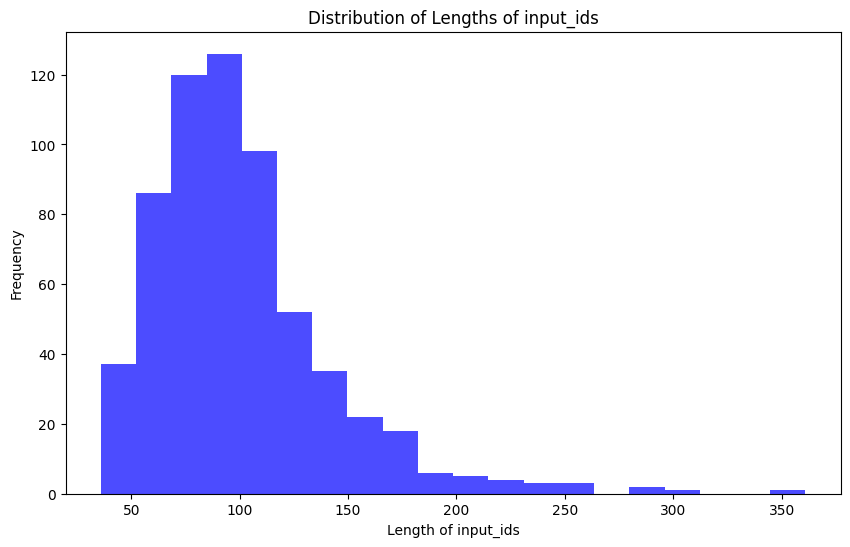

In [ ]:
import matplotlib.pyplot as plt

def plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset):
    lengths = [len(x['input_ids']) for x in tokenized_train_dataset]
    lengths += [len(x['input_ids']) for x in tokenized_val_dataset]
    print(len(lengths))

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.show()

plot_data_lengths(tokenised_Train_dataset, tokenised_valid_dataset)

In [ ]:
max_length = 200

In [ ]:
def generate_and_tokenize_prompt2(prompt):
    result = tokenizer(
        formatting_func(prompt),
        truncation=True,
        max_length=max_length,
        padding="max_length",
    )
    result["labels"] = result["input_ids"].copy()
    return result

In [ ]:
tokenized_train_dataset = Train_data.map(generate_and_tokenize_prompt2)
tokenized_val_dataset = Validation_data.map(generate_and_tokenize_prompt2)

619


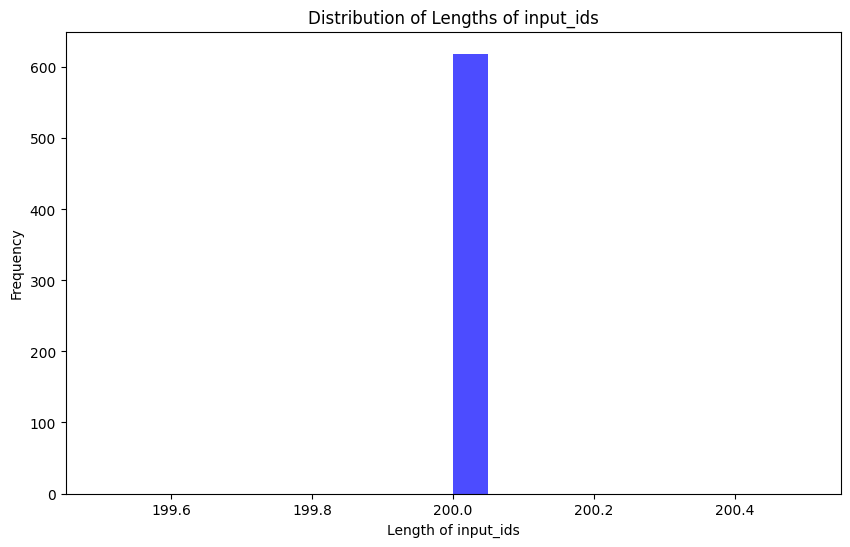

In [ ]:
plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

Pre_Training Eval Prompt

In [ ]:
eval_prompt = "write some resume points on mars roverteam"

In [ ]:

model_input = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

model.eval()
with torch.no_grad():
    print(tokenizer.decode(model.generate(**model_input, max_new_tokens=256, repetition_penalty=1.15)[0], skip_special_tokens=True))

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1473: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


write some resume points on mars roverteam

* Worked as a software engineer for the Mars Rover team at NASA's Jet Propulsion Laboratory (JPL)
* Developed and maintained software systems for the Mars Science Laboratory mission, including the Curiosity rover
* Collaborated with cross-functional teams to design and implement new features for the rovers
* Conducted testing and debugging of software systems to ensure they met mission requirements
* Participated in code reviews and contributed to the development of best practices for software engineering within the JPL organization.


In [ ]:
from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

In [ ]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [ ]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=16,
    lora_alpha=64,
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
        "lm_head",
    ],
    bias="none",
    lora_dropout=0.05,  # Conventional
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

trainable params: 42520576 || all params: 3794591744 || trainable%: 1.1205573318192514


In [ ]:
from accelerate import FullyShardedDataParallelPlugin, Accelerator
from torch.distributed.fsdp.fully_sharded_data_parallel import FullOptimStateDictConfig, FullStateDictConfig

fsdp_plugin = FullyShardedDataParallelPlugin(
    state_dict_config=FullStateDictConfig(offload_to_cpu=True, rank0_only=False),
    optim_state_dict_config=FullOptimStateDictConfig(offload_to_cpu=True, rank0_only=False),
)

accelerator = Accelerator(fsdp_plugin=fsdp_plugin)

In [ ]:
model = accelerator.prepare_model(model)

In [ ]:
import wandb, os
wandb.login()

wandb_project = "journal-finetune"
if len(wandb_project) > 0:
    os.environ["WANDB_PROJECT"] = wandb_project

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: ERROR API key must be 40 characters long, yours was 38


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
if torch.cuda.device_count() > 1: # If more than 1 GPU
    model.is_parallelizable = True
    model.model_parallel = True

In [ ]:
import transformers
from datetime import datetime

project = "journal-finetune"
base_model_name = "mistral"
run_name = base_model_name + "-" + project
output_dir = "./" + run_name

trainer = transformers.Trainer(
    model=model,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    args=transformers.TrainingArguments(
        output_dir=output_dir,
        warmup_steps=1,
        per_device_train_batch_size=2,
        gradient_accumulation_steps=1,
        gradient_checkpointing=True,
        max_steps=1000,
        learning_rate=2.5e-5, # Want a small lr for finetuning
        # bf16=True,
        optim="paged_adamw_8bit",
        logging_steps=25,              # When to start reporting loss
        logging_dir="./logs",        # Directory for storing logs
        save_strategy="steps",       # Save the model checkpoint every logging step
        save_steps=25,                # Save checkpoints every 50 steps
        evaluation_strategy="steps", # Evaluate the model every logging step
        eval_steps=25,               # Evaluate and save checkpoints every 50 steps
        do_eval=True,                # Perform evaluation at the end of training
        report_to="wandb",           # Comment this out if you don't want to use weights & baises
        run_name=f"{run_name}-{datetime.now().strftime('%Y-%m-%d-%H-%M')}"          # Name of the W&B run (optional)
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

model.config.use_cache = False  # silence the warnings. Please re-enable for inference!


In [ ]:
for name, module in trainer.model.named_modules():
    if "norm" in name:
        module = module.to(torch.float32)

In [ ]:
trainer.train()

You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss
25,3.044500,2.351199
50,2.365900,2.227756
75,2.284600,2.183773
100,2.397000,2.171330
125,2.116500,2.144580
150,2.121800,2.134288
175,2.147700,2.116076
200,2.138200,2.120658
225,2.107400,2.126727
250,2.236800,2.112506


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.

KeyboardInterrupt: ignored

We stopped the training in the middle as you see model start to overfit the training data 

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "bn22/Mistral-7B-Instruct-v0.1-sharded"
# we are using bitsandbytes to load the model in quantise format 
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)
# Load the pre-trained model for causal language modeling
base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,  # Mistral, same as before
    quantization_config=bnb_config,  # Same quantization config as before
    device_map="auto",
    trust_remote_code=True,

)

# Load the tokenizer for the specified model
tokenizer = AutoTokenizer.from_pretrained(base_model_id, add_bos_token=True, trust_remote_code=True)

Loading checkpoint shards:   0%|          | 0/11 [00:00<?, ?it/s]

In [ ]:
from peft import PeftModel

ft_model = PeftModel.from_pretrained(base_model, "/content/mistral-journal-finetune/checkpoint-250")

EXAMPLES

In [ ]:
eval_prompt = " write some resume points on bubble trouble game cs101: # "
model_input = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=300, repetition_penalty=1.2, top_k=4, do_sample = True)[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 write some resume points on bubble trouble game cs101: # 
 ### Answer (4) | 56%
 - Developed a multi-level, physics based puzzle in which the user had to use logic and timing skills to progress from stage to stage
### Game Development Project (32%)
 - Worked as part of an eight member team developing a two player strategy game using C++ programming language
### Course Projects (8%)
- Participated in course projects including a web scraping project that involved extracting data from websites, and an image processing project that used machine learning techniques to classify images


In [ ]:
eval_prompt = " write some resume points on Risc pipelined: # "
model_input = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=300, repetition_penalty=1.2, top_k=4, do_sample = True)[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 write some resume points on Risc pipelined: # 2017
 ### Coursework | Department of Computer Science, IIT Bombay
 * Pipelining: Implemented a multi-stage processor with hazard mitigation and forward data flow.
* Data Flow Simulation: Developed a simulator for the pipeline to analyze performance under different conditions.
* Register Allocation: Designed an algorithm to optimize register allocation in the pipeline using heuristics. (‘16)


In [ ]:
eval_prompt = " write some resume points on XLR8: # "
model_input = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=300, repetition_penalty=1.2, top_k=4, do_sample = True)[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 write some resume points on XLR8: # 13
 ### Answer (text) ['XLR8 is a novel, multi-modal audio and speech processing system that can be used in various scenarios', 'The core of the system includes an acoustic model trained on over 600 hours of speech data from multiple speakers']
### Answer (text) ["Designed and developed algorithms to improve the accuracy of speaker diarization", 'Implemented techniques such as Gaussian mixture models (GMM), clustering, and deep neural networks (DNN')
## Answer (text) ['Performed experiments using both synthetic and real-world speech datasets to evaluate the performance of the system.', 'Analyzed results and identified areas for further improvement, such as incorporating more diverse speaker samples.']


In [ ]:
eval_prompt = " write some resume points on Optimal Placement of Sensor nodes | Supervised Learning Project: # "
model_input = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=300, repetition_penalty=1.2, top_k=4, do_sample = True)[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 write some resume points on Optimal Placement of Sensor nodes | Supervised Learning Project: # 1
 ### Answer: ['Developed a novel method to optimally position sensor nodes in the network for efficient communication.', 'Implemented various techniques including clustering, regression and reinforcement learning algorithms to achieve optimal placement.']


In [ ]:
eval_prompt = " write some resume points on Trajectory Simulation of Sentinel-3A Satellite Launch | Spaceflight Mechanics: # "
model_input = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=300, repetition_penalty=1.2, top_k=4, do_sample = True)[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 write some resume points on Trajectory Simulation of Sentinel-3A Satellite Launch | Spaceflight Mechanics: # 106
 ### Answer: ['Performed trajectory simulation using CAD software SolidWorks for satellite launch from Earth.', 'Generated a 2D and a 3D model of the satellite, rocket and their components using CATIA V5.']
### Answer: [‘Analyzed the trajectory of the satellite using MSC Software to calculate the time of flight of the satellite.', 'Evaluated the velocity vector of the satellite during the launch phase by considering various parameters like altitude change rate, acceleration due to gravity etc.’]


In [ ]:
import shutil

folder_path = '/content/mistral-journal-finetune/checkpoint-250'
shutil.make_archive('/content/folder_download', 'zip', folder_path)


'/content/folder_download.zip'

In [ ]:
eval_prompt = " write some resume points on Stock trading price prediction: # "
model_input = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=300, repetition_penalty=1.2, top_k=4, do_sample = True)[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 write some resume points on Stock trading price prediction: # 
 ### Answer: ['Performed a time series analysis to identify the factors that affect stock prices', 'Developed an AI-based predictive model using regression and classification techniques', 'Generated insights into future trends by analyzing past performance data']


In [ ]:
eval_prompt = " write some resume points on Q-learning RL: # "
model_input = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=300, repetition_penalty=1.2, top_k=4, do_sample = True)[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 write some resume points on Q-learning RL: # 2017
 ### Answer (4)
 ['Built a neural network model for image classification using convolutional layers and batch normalisation.']


In [ ]:
eval_prompt = " write some resume points on Playing tic-tac-toe with AI using minmax algorithm and alpha beta pruning: # "
model_input = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=300, repetition_penalty=1.2, top_k=4, do_sample = True)[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 write some resume points on Playing tic-tac-toe with AI using minmax algorithm and alpha beta pruning: # 
 ### Answer: ['Played Tic Tac Toe with a self implemented AI that used the minimax algorithm and alpha beta pruning', 'Developed an interface to display game state, make moves, and end the game']


In [ ]:
eval_prompt = " write some resume points on hf rador: # "
model_input = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=300, repetition_penalty=1.2, top_k=4, do_sample = True)[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 write some resume points on hf rador: # 10
 ### Answer (4)
 - Developed an algorithm in C++ to detect and track objects of a specific size in real-time using the HSV color space. The algorithm uses a circular buffer and a Kalman filter to predict object positions, and a sliding window to estimate distances. It is capable of tracking up to three objects simultaneously, and has been tested on various video clips.


In [ ]:
eval_prompt = " write some resume points on face recognition: # "
model_input = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=300, repetition_penalty=1.2, top_k=4, do_sample = True)[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 write some resume points on face recognition: # 
 ### Answer [['Developed a novel algorithm based on PCA and Lasso Regression for Face Recognition.', 'Performed experiments on MTCAS dataset to evaluate the accuracy of the proposed method.']]


In [ ]:
eval_prompt = " write some resume points on Malware Detector-Classifier: # "
model_input = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=300, repetition_penalty=1.2, top_k=4, do_sample = True)[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 write some resume points on Malware Detector-Classifier: # 10+ million malwares in 2.5GB dataset; 98.4% accuracy
 ### Answer: ['Developed a malware classifier using machine learning techniques to detect over 10 million malware samples from a 2.5 billion byte dataset.', 'Achieved an accuracy of 98.4% by implementing various algorithms and optimizing the model for better performance.']


In [ ]:
eval_prompt = " write some resume points on Institute Student Mentor (ISMP) and Department Academic Mentor (D-AMP) : # "
model_input = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=300, repetition_penalty=1.2, top_k=4, do_sample = True)[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 write some resume points on Institute Student Mentor (ISMP) and Department Academic Mentor (D-AMP) : # 106
 ### Answer [‘18, ‘23]
* Mentored freshmen in ISMP to facilitate smooth academic and personal growth; provided guidance on course selection, extracurricular activities, internships, research opportunities, etc., resulting in a 95% satisfaction rate among mentees.
* Conducted weekly meetings with mentors & organized seminars/workshops for the development of interpersonal communication skills, problem solving abilities, leadership qualities, time management, and stress handling techniques.


In [ ]:
eval_prompt = " write some resume points on Deployed a novel audio-visual dataset generation pipeline to process 7.5 hr of video content in 1 hr to generate 1100+ samples: # "
model_input = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=300, repetition_penalty=1.2, top_k=4, do_sample = True)[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 write some resume points on Deployed a novel audio-visual dataset generation pipeline to process 7.5 hr of video content in 1 hr to generate 1100+ samples: # 
 ### Answer: ['Deployed an audio-video dataset generation pipeline for processing over 7 hours of video content in just 1 hour.', 'Generated over 1,100 samples using the newly developed method.']


In [ ]:
eval_prompt = " write some resume points on TUB university: # "
model_input = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=300, repetition_penalty=1.2, top_k=4, do_sample = True)[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 write some resume points on TUB university: # 120+ international students from 35 different countries; mentoring 8 freshmen
 ### Answer (4): ['Mentored and guided a team of 6 international undergraduate students in their academic pursuits.', 'Assisted the International Student Coordinator in managing international student events and organizing cultural exchange activities.']
### Answer (9): ['Organized an international food festival featuring cuisines from more than 15 countries, with over 250 attendees.']
## Answer (1)

* Organised the annual sports day event for 500 participants and 7 teams from various colleges
* Managed the budget of INR 2 million for organising the event
* Led the coordination efforts for all sports events, including track meets, volleyball tournaments, basketball games and football matches
* Maintained communication between the college management, faculty members, athletes, coaches and sponsors


In [ ]:
eval_prompt = " write some resume points on Musify music implementaion using AI: # "
model_input = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=300, repetition_penalty=1.2, top_k=4, do_sample = True)[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 write some resume points on Musify music implementaion using AI: # 
 ### Answer (0)
 ['Implemented a music player in python that utilizes AI to suggest songs based on the current song being played.', 'Used machine learning algorithms like k-means and clustering to generate recommendations for the user.']


In [ ]:
eval_prompt = " write some resume points on Digital circuits lab: # "
model_input = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=300, repetition_penalty=1.2, top_k=4, do_sample = True)[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 write some resume points on Digital circuits lab: # 
 ### Answer: ['Studied the fundamentals of digital logic, sequential and combinational circuits', 'Implementing digital logic using T flip-flops, D flip-flops and JK flip-flops']
### answer: ['Developed an understanding of the principles of memory hierarchy and data storage devices']
### answer: ['Examined the operation of various types of computer architectures such as CISC and RISC']

# Answer: ['Analyzed the working of microprocessors and its components such as CPU, RAM, cache and bus']
# ['Studied the concept of interrupt driven systems and how it works in modern computing systems']
